In [1]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('../../')
from VisUtils import *
from split_data import *
from RF_Utils import *
from GPUtils import * 
# from GPUtils import DirichletGPModel
from sklearn.metrics import confusion_matrix
import itertools

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, PrecisionRecallDisplay

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_95917/4192114624.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
# file = 'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv'
# all_fold_df = look_at_data(split_path+'NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

In [3]:
# Transform data to PyTorch tensors

# Scale data
# x_df = pd.concat([train_x_df, test_x_df])

# scaling=StandardScaler()

# Use fit and transform method 
# scaling.fit(x_df)
# Scaled_data=scaling.transform(x_df)
# train_scaled_data = scaling.transform(train_x_df)
# test_scaled_data = scaling.transform(test_x_df) 

split_path = '../../../../../data/NEK_data_4Berkeley/NEK2/inhib/'
# /Users/jayceepang/msse/capstone/data/NEK_data_4Berkeley/NEK2/NEK2_binding_random_fold1_testY.csv

train_x_df_temp = pd.read_csv(split_path+"inhib_train_x_normMorgan2.csv",header=None)
train_y_df_temp = pd.read_csv(split_path+"inhib_train_y_normMorgan2.csv",header=None)
test_x_df = pd.read_csv(split_path+"inhib_test_x_normMorgan2.csv",header=None)
test_y_df = pd.read_csv(split_path+"inhib_test_y_normMorgan2.csv",header=None)

train_x_temp = train_x_df_temp.to_numpy().astype("long")
test_x_temp = test_x_df.to_numpy().astype("long")

train_y_temp = train_y_df_temp.to_numpy().flatten().astype("long")
test_y_temp = test_y_df.to_numpy().flatten().astype("long")

train_x = torch.from_numpy(train_x_temp)
train_y = torch.from_numpy(train_y_temp)
test_x = torch.from_numpy(test_x_temp)
test_y = torch.from_numpy(test_y_temp)


print(train_x.shape) 
print(train_y.shape) 

torch.Size([1125, 2048])
torch.Size([1125])


In [25]:
class Trainer: 
    def __init__(self,model, likelihood, iterations): 
        self.model = model
        self.likelihood = likelihood 

        smoke_test = ('CI' in os.environ)
        self.n_iterations = 2 if smoke_test else iterations
        # self.n_iterations = n_iterations 
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        # loss function 
        self.loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)
    def train(self, train_x, train_y): 
        self.model.train()
        self.likelihood.train()
        predictions = [] 
        for i in range(self.n_iterations): 
            self.optimizer.zero_grad()
            output = self.model(train_x)
            loss = -self.loss_fn(output, self.likelihood.transformed_targets).sum()
            loss.backward()
            if (i%10==0): 
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, self.n_iterations, loss.item(),
                    self.model.covar_module.base_kernel.lengthscale.mean().item(),
                    self.model.likelihood.second_noise_covar.noise.mean().item()
                ))
             
          
            self.optimizer.step() 


    def predict(self, input): 
        # predict on validation set? 
        self.model.eval()
        self.likelihood.eval()

        with gpytorch.settings.fast_pred_var(), torch.no_grad():
            dist = self.model(input)     # output distribution
            pred_means = dist.loc          # means of distributino 
            # f_samples = dist.sample(sample_shape=torch.Size(1000))    
            observed_pred = self.likelihood(self.model(input))    # likelihood predictions mean and var  
            # class_pred = self.model(input).loc.max(0)[1].numpy()  # predictions (0 or 1) 
            class_pred = self.model(input).loc.max(0)[1]
            
        return dist, observed_pred, pred_means,class_pred
    

    def evaluate(self, x_input, y_true): 
        y_pred = self.model(x_input).loc.max(0)[1].numpy()
        
        return y_pred

    def gp_results(self, x_input, y_true, plot_title): 
        y_pred = self.evaluate(x_input, y_true) 
        if isinstance(y_true, torch.Tensor):
            y_true = y_true.numpy().reshape(-1)
        # cm = confusion_matrix(y_true, y_pred)
        plot_confusion_matrix(y_true, y_pred, ['0','1'], title=plot_title)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        dist = self.model(x_input)     # get predicted distributions 
        pred_means = dist.loc          # means for predicted dist  

        recall = recall_score(y_true, y_pred)
        tp, tn, fp, fn = calculate_metrics(y_true, y_pred) 
        sensitivity = tp / (tp + fn) 
        specificity = tn / (tn + fp) 
        print(f'accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}, specificity: {specificity:.4f}')
        return {'accuracy': accuracy, 'precision': precision,  'recall':recall, 'specificity':specificity}

       

In [5]:
likelihood1 = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model1 = DirichletGPModel(train_x, likelihood1.transformed_targets, likelihood1, num_classes=likelihood1.num_classes)
n_iterations = 300
trainer1 = Trainer(model1, likelihood1, n_iterations)
trainer1.train(train_x, train_y) 

Iter 1/300 - Loss: 7.095   lengthscale: 0.693   noise: 0.693
Iter 11/300 - Loss: 5.465   lengthscale: 1.100   noise: 0.809
Iter 21/300 - Loss: 4.322   lengthscale: 1.768   noise: 1.068
Iter 31/300 - Loss: 3.338   lengthscale: 2.760   noise: 1.261
Iter 41/300 - Loss: 3.191   lengthscale: 3.816   noise: 1.288
Iter 51/300 - Loss: 3.141   lengthscale: 4.722   noise: 1.222
Iter 61/300 - Loss: 3.125   lengthscale: 5.471   noise: 1.114
Iter 71/300 - Loss: 3.106   lengthscale: 6.056   noise: 0.992
Iter 81/300 - Loss: 3.091   lengthscale: 6.503   noise: 0.866
Iter 91/300 - Loss: 3.068   lengthscale: 6.850   noise: 0.748
Iter 101/300 - Loss: 3.061   lengthscale: 7.133   noise: 0.644
Iter 111/300 - Loss: 3.059   lengthscale: 7.370   noise: 0.557
Iter 121/300 - Loss: 3.049   lengthscale: 7.576   noise: 0.488
Iter 131/300 - Loss: 3.049   lengthscale: 7.760   noise: 0.434
Iter 141/300 - Loss: 3.049   lengthscale: 7.927   noise: 0.394
Iter 151/300 - Loss: 3.041   lengthscale: 8.076   noise: 0.365
Ite

/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


accuracy: 0.9600, precision: 0.0000, recall: 0.0000, specificity: 1.0000
accuracy: 0.9576, precision: 0.0000, recall: 0.0000, specificity: 1.0000


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x400 with 0 Axes>

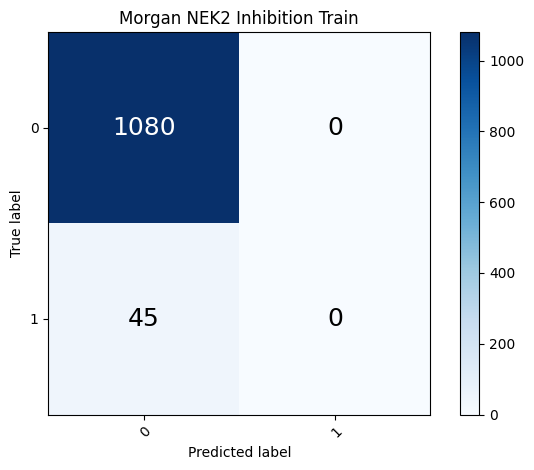

<Figure size 600x400 with 0 Axes>

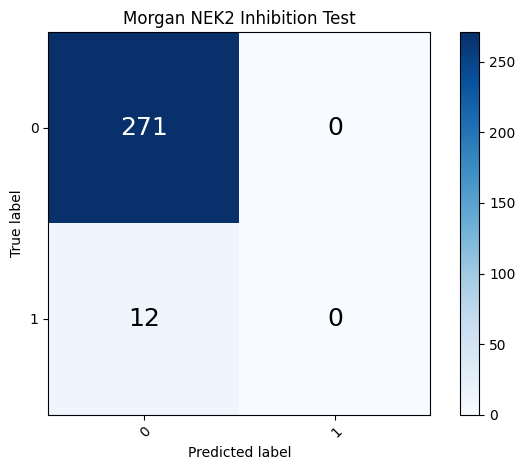

In [6]:
# get predictions of train x input
train_dist, train_observed_pred, train_pred_means, train_pred  = trainer1.predict(train_x)
train_results1 = trainer1.gp_results(train_x, train_y, 'Morgan NEK2 Inhibition Train')

test_dist, test_observed_pred, test_pred_means, test_pred  = trainer1.predict(test_x)
test_results1 = trainer1.gp_results(test_x, test_y, 'Morgan NEK2 Inhibition Test')


In [ ]:
gp_metrics = [train_results1, test_results1]
# with open('nek2_inhib_gp_metrics_normfeats.pkl', 'wb') as file: 
#     pickle.dump(gp_metrics, file) 
gp_metrics

# Probabilities and Variance 

In [26]:
# train_pred = train_observed_pred
train_observed_pred.mean.numpy()
train_pred_variance2D = train_observed_pred.variance.numpy()
# test_pred = test_observed_pred
test_observed_pred.mean.numpy()
test_pred_variance2D=test_observed_pred.variance.numpy()
var_min = test_pred_variance2D.min(axis=0).min()
var_max = test_pred_variance2D.max(axis=0).max()
var_min, var_max
# train_observed_pred.variance.numpy()
# test_observed_pred.variance.numpy()

(0.002841451, 2.8391593)

In [8]:

train_pred_samples = train_dist.sample(torch.Size((256,))).exp()
train_probabilities = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).mean(0)
train_probabilities.shape 
train_prob_stds = (train_pred_samples / train_pred_samples.sum(-2, keepdim=True)).std(0)
train_prob_stds.shape

lower, upper = test_observed_pred.confidence_region()

# # Generate samples to get probabilities
pred_samples = test_dist.sample(torch.Size((100,))).exp()
pred_samples.shape
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
prob_stds = (pred_samples / pred_samples.sum(-2, keepdim=True)).std(0)


/Users/jayceepang/msse/capstone/gpytorch-venv/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


In [9]:
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()
train_perf_df['mean_pred_class0'] = train_observed_pred.mean.numpy()[0,]
train_perf_df['mean_pred_class1'] = train_observed_pred.mean.numpy()[1,]
train_perf_df['y'] = train_y
train_perf_df['y_pred'] = train_pred_means.max(0)[1]
train_perf_df['var_pred_class0']=train_observed_pred.variance.numpy()[0,]
train_perf_df['var_pred_class1']=train_observed_pred.variance.numpy()[1,]
train_perf_df['pred_prob_class0'] = train_probabilities.numpy()[0,]
train_perf_df['pred_prob_class1'] = train_probabilities.numpy()[1,]
train_perf_df['pred_prob_std_class0'] = train_prob_stds.numpy()[0,]
train_perf_df['pred_prob_std_class1'] = train_prob_stds.numpy()[1,]

test_perf_df['mean_pred_class0'] = test_observed_pred.mean.numpy()[0,]
test_perf_df['mean_pred_class1'] = test_observed_pred.mean.numpy()[1,]
test_perf_df['y'] = test_y
test_perf_df['y_pred'] = test_pred_means.max(0)[1]
test_perf_df['var_pred_class0']=test_observed_pred.variance.numpy()[0,]
test_perf_df['var_pred_class1']=test_observed_pred.variance.numpy()[1,]
test_perf_df['pred_prob_class0'] = probabilities.numpy()[0,]
test_perf_df['pred_prob_class1'] = probabilities.numpy()[1,]
test_perf_df['pred_prob_std_class0'] = prob_stds.numpy()[0,]
test_perf_df['pred_prob_std_class1'] = prob_stds.numpy()[1,]

train_perf_df.to_csv("model_performance/NEK2_inhib_normMorgan_train_perf.csv", index=False)
test_perf_df.to_csv("model_performance/NEK2_inhib_normMorgan_test_perf.csv", index=False)

In [15]:
# get train samples 

# TRAIN
# plot_heatmap(train_dist, train_observed_pred, train_probabilities, 'train')

In [ ]:
# TEST SET
# # Get confidence regions 
# confidence 
# plot_heatmap(test_dist, test_observed_pred, probabilities, 'test')

In [ ]:
# plot_hist(train_observed_pred, 'train')
# plot_hist(test_observed_pred, 'test')

# plot_cm_dist_kde(test_observed_pred, test_pred, test_y, 'Binding, test')

In [ ]:
# plot_cm_dist(train_observed_pred, train_pred, train_y, 'train')
# plot_cm_dist(test_observed_pred, test_pred, test_y, 'test')


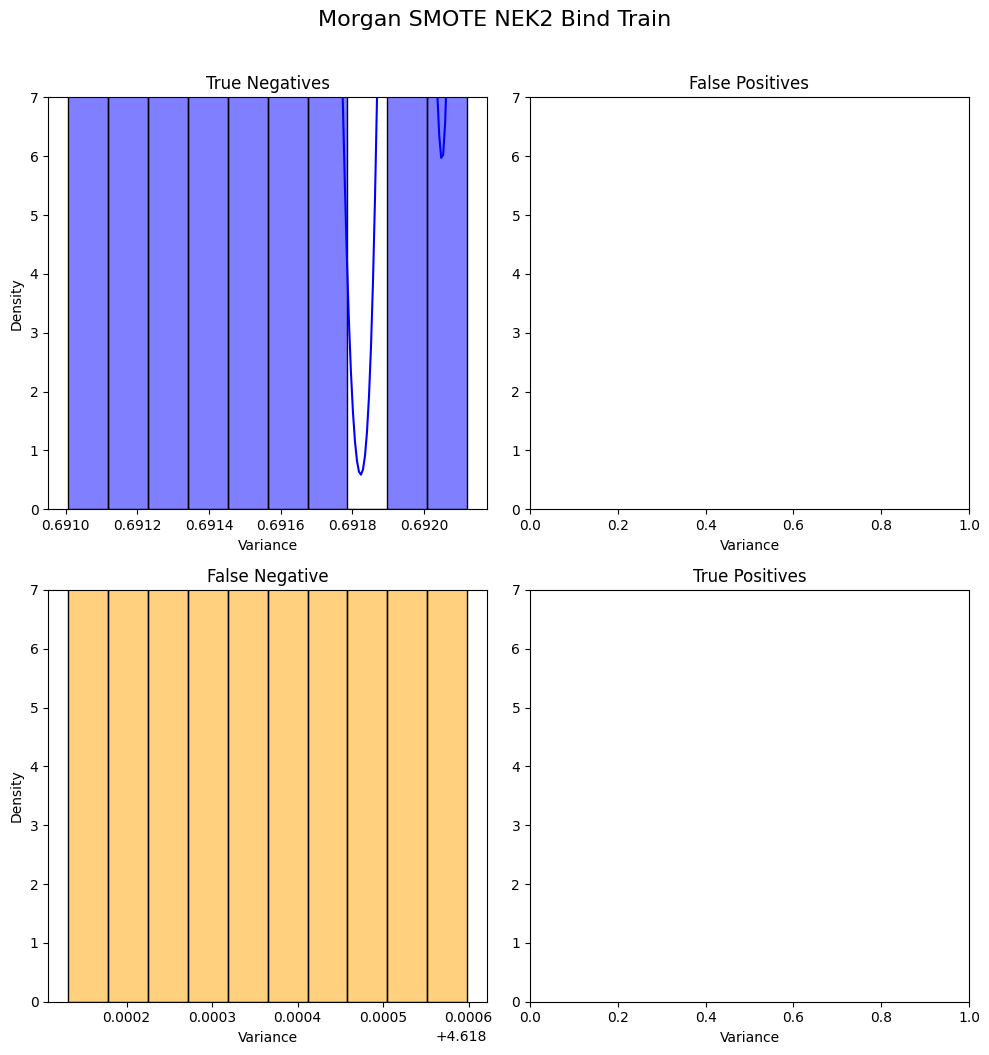

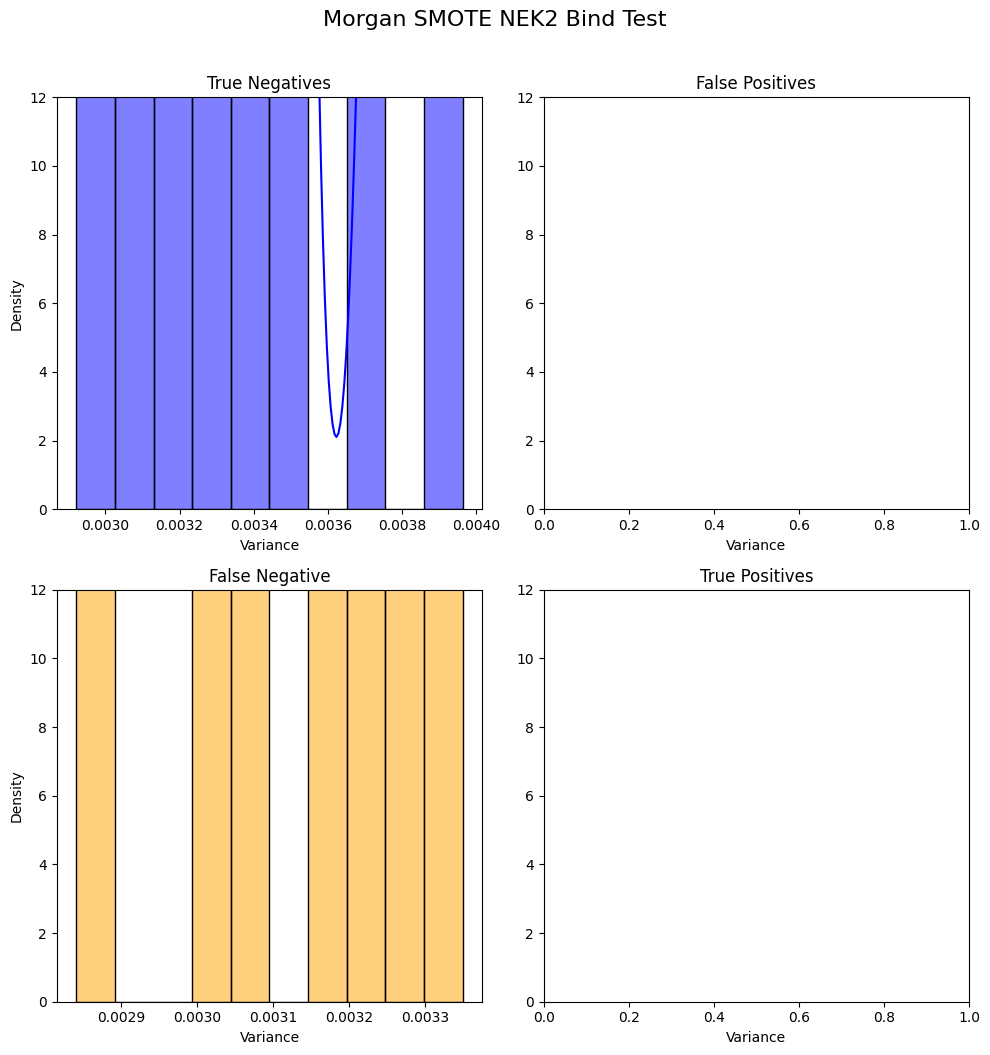

In [16]:
plot_cm_dist_kdedensity(train_observed_pred, train_pred, train_y, 'Morgan SMOTE NEK2 Bind Train',7)
plot_cm_dist_kdedensity(test_observed_pred, test_pred, test_y, 'Morgan SMOTE NEK2 Bind Test',12)

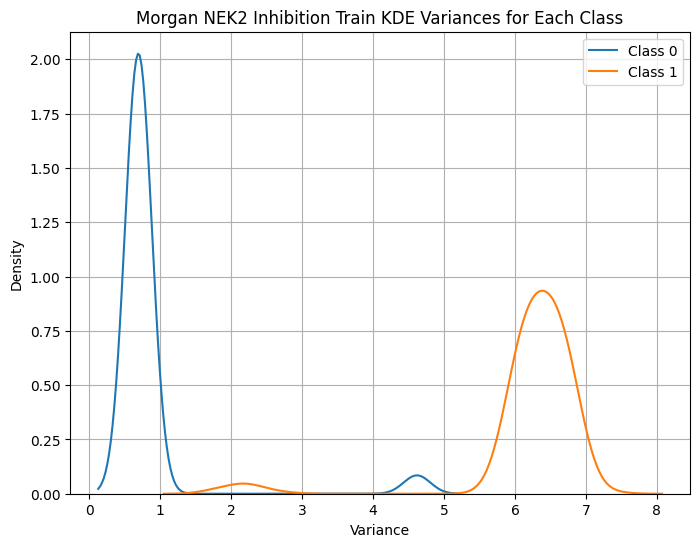

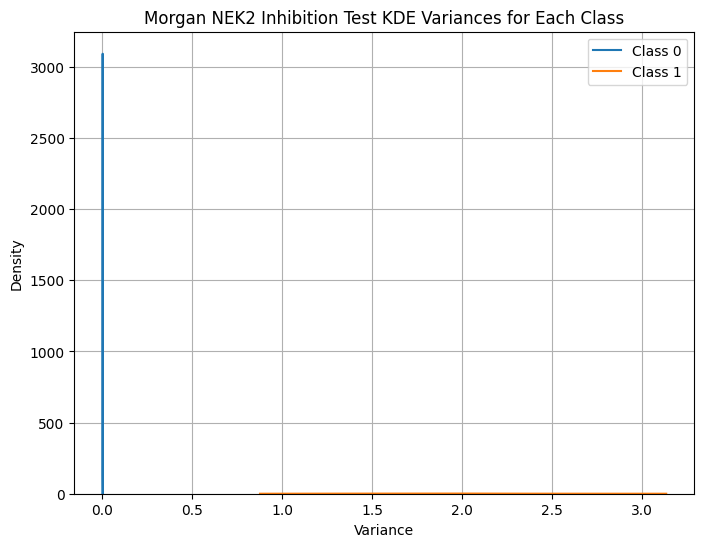

In [17]:
plot_kde(train_observed_pred, 'Morgan NEK2 Inhibition Train')
plot_kde(test_observed_pred, 'Morgan NEK2 Inhibition Test')
# plot_hist(test_observed_prt')


In [ ]:
# plot_roc(test_y, probabilities)

<Figure size 800x600 with 0 Axes>

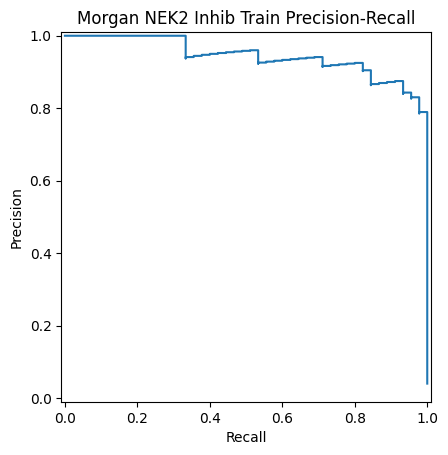

<Figure size 800x600 with 0 Axes>

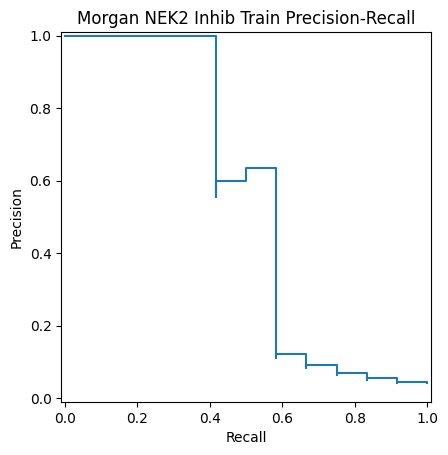

In [18]:
plot_prec_recall(train_y, train_probabilities.numpy()[1,:], 'Morgan NEK2 Inhib Train Precision-Recall')
plot_prec_recall(test_y, probabilities.numpy()[1,:],'Morgan NEK2 Inhib Train Precision-Recall')

In [19]:
test_observed_pred.mean.numpy() # test_pred.mean.numpy()  observed_pred = self.likelihood(self.model(input)) 
test_pred_variance2D = test_observed_pred.variance.numpy()
print(test_observed_pred.variance.numpy().shape)
test_pred_variance2D
test_pred_variance = [test_pred_variance2D[value][idx] for idx,value in enumerate(test_pred)]

(2, 283)


In [20]:
probabilities.numpy()[1,].shape

(283,)

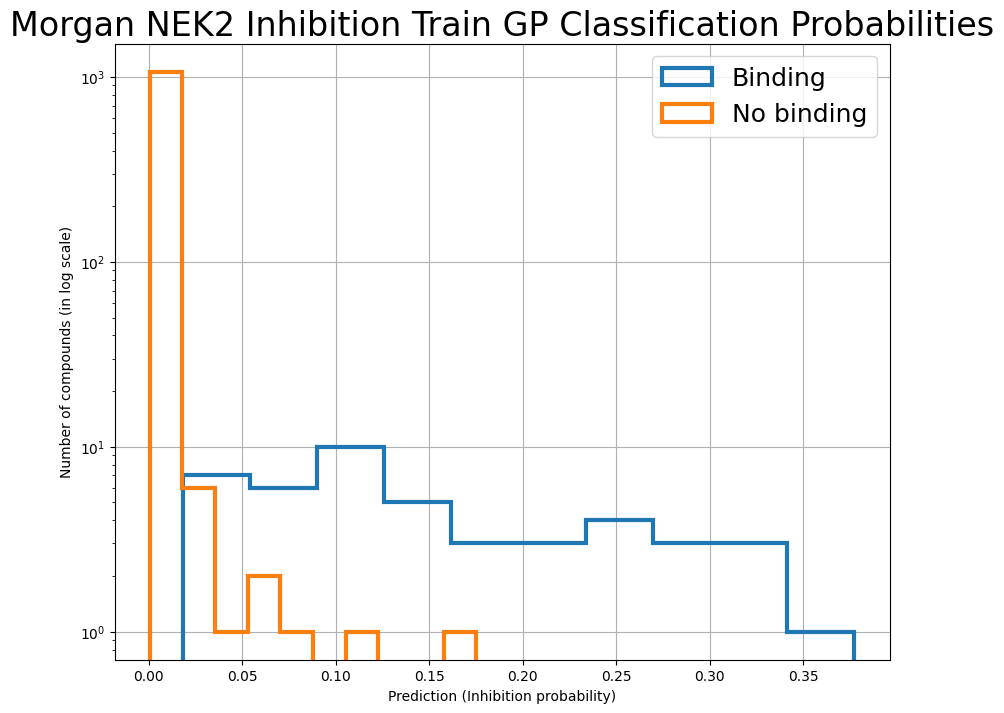

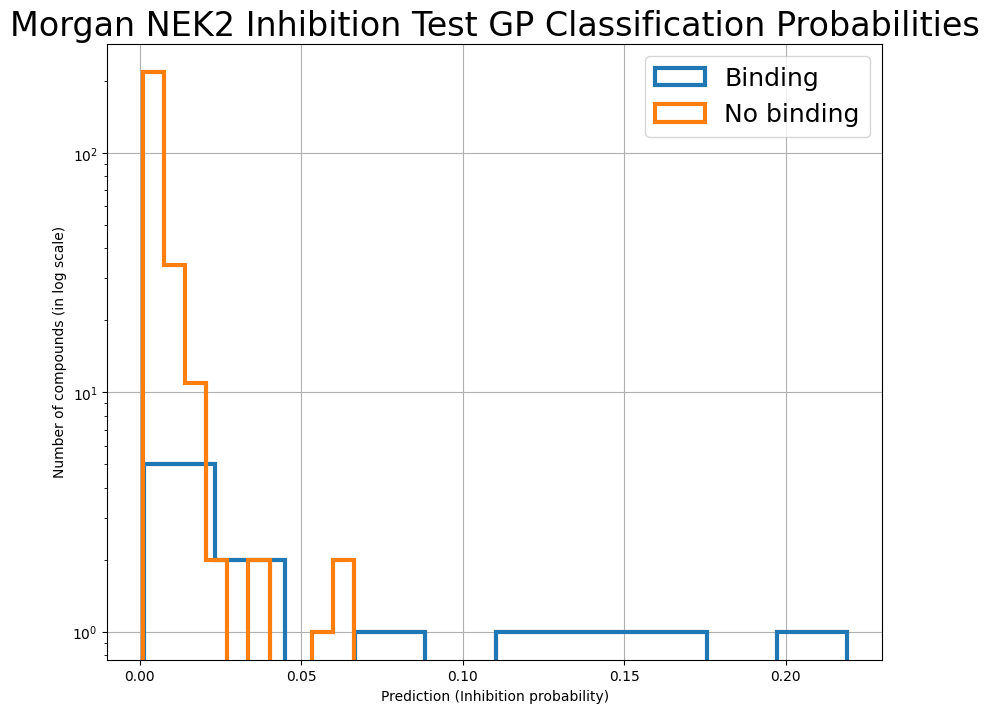

In [21]:

plot_prob_hist(train_probabilities, train_y, 'Morgan NEK2 Inhibition Train GP Classification Probabilities', 'Inhibition')
plot_prob_hist(probabilities, test_y, 'Morgan NEK2 Inhibition Test GP Classification Probabilities', 'Inhibition')

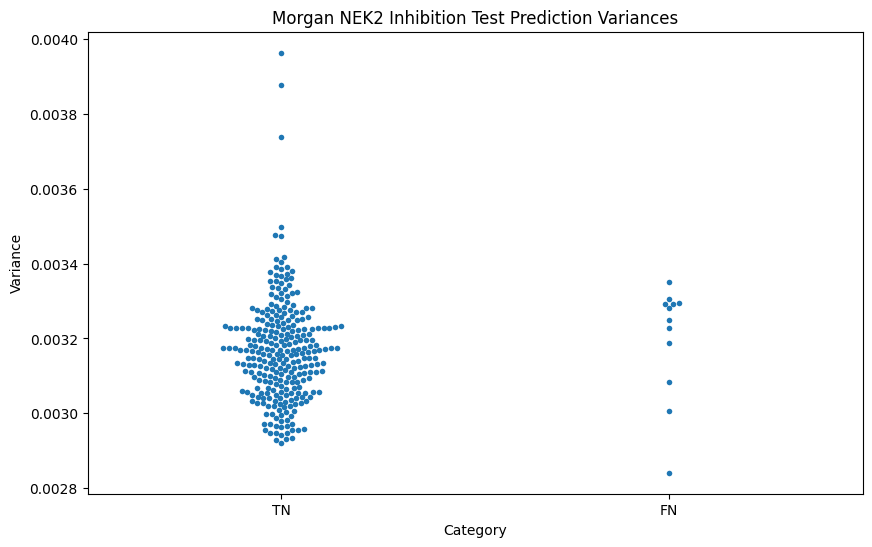

In [22]:
# plot_swarmplot(train_pred, train_y, train_observed_pred,'Morgan NEK2 Inhibition Train Prediction Variances')
plot_swarmplot(test_pred, test_y, test_observed_pred,'Morgan NEK2 Inhibition Test Prediction Variances')

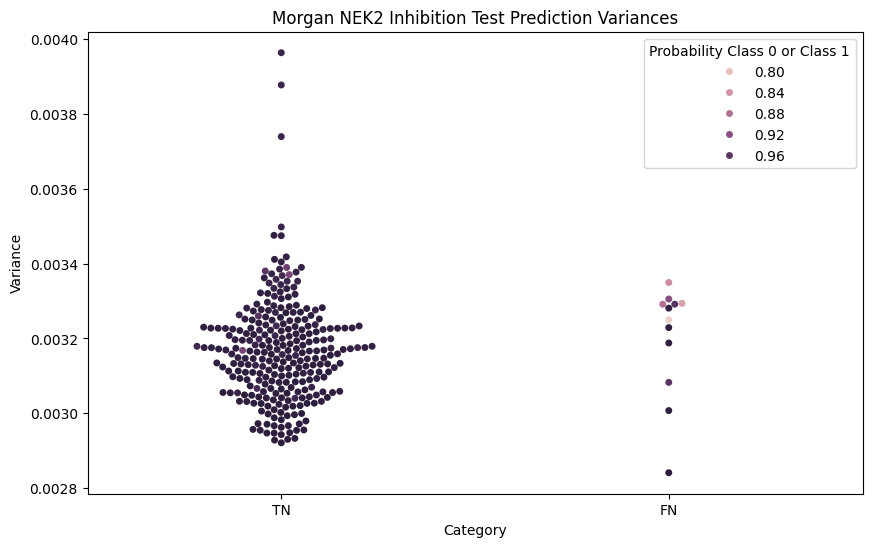

In [24]:
swarm_by_var_and_prob(test_pred, test_y, test_observed_pred,probabilities,'Morgan NEK2 Inhibition Test Prediction Variances')

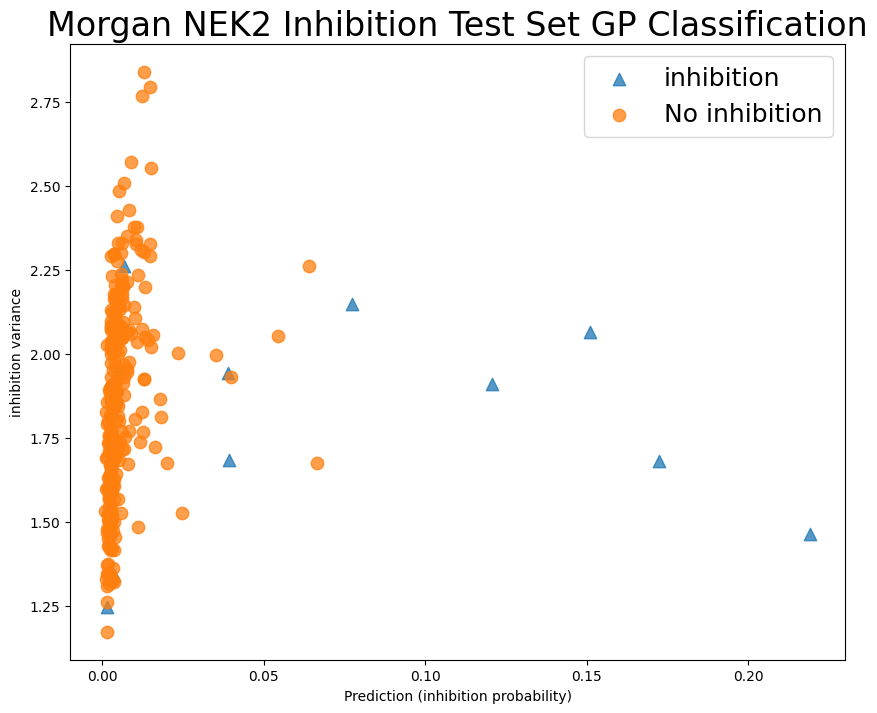

In [23]:
# probabilities_vs_var(train_y, train_probabilities, train_observed_pred,'Morgan NEK2 Inhibition Train Set GP Classification', 'inhibition')
probabilities_vs_var(test_y, probabilities, test_observed_pred,'Morgan NEK2 Inhibition Test Set GP Classification', 'inhibition')

In [ ]:
# indices0 = np.where(test_pred == 0)[0]
# indices1 = np.where(test_pred == 1)[0]

# var_class0 = test_observed_pred.variance[0].numpy()
# var_class1 = test_observed_pred.variance[1].numpy()
# plt.errorbar(indices0, test_pred[indices0], 
#              xerr=var_class0[indices0], fmt='o', label='Class 0')

# plt.errorbar(indices1, test_pred[indices1], 
#              xerr=var_class1[indices1], fmt='o', label='Class 1')


# plt.xlabel('Predictions')
# plt.yticks([0, 1], ['0', '1'])
# plt.title('Prediction variances')
# plt.legend()
# plt.show()

In [ ]:
# dist = trainer1.model(test_x)
# pred_varainces = dist.variance
# normalized = pred_varainces/pred_varainces.max() 
# normalized.shape
# plt.figure(figsize=(8, 6))
# plt.imshow(normalized.detach().numpy(), cmap='viridis', interpolation='nearest')
# plt.colorbar(label='Confidence Score')
# plt.title('Confidence Heatmap')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.show()

In [ ]:
# plot_variance_cm(test_observed_pred, test_y.numpy(), test_pred, 'test')

In [ ]:
marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig, ax = plt.subplots(2, 2, figsize=(25, 15))
true_labels = test_y.numpy()


true_pos = np.where((test_pred == 1) & (true_labels == 1))[0] 
true_neg = np.where((test_pred == 0) & (true_labels == 0))[0]
false_pos = np.where((test_pred == 1) & (true_labels == 0))[0] 
false_neg = np.where((test_pred == 0) & (true_labels == 1))[0] 

var_tp = test_observed_pred.variance[1, true_pos].numpy()
var_tn = test_observed_pred.variance[0, true_neg].numpy()
var_fp = test_observed_pred.variance[1, false_pos].numpy()
var_fn = test_observed_pred.variance[0, false_neg].numpy()

sc_tp = ax[0, 0].scatter(true_pos, (test_y[true_pos] - test_pred[true_pos]), c=test_pred_variance2D[1, true_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[0])
ax[0, 0].set_title('True Positives')
ax[0, 0].set_xlabel('Data index')
ax[0, 0].set_ylabel('Actual - Predicted')


sc_tn = ax[0, 1].scatter(true_neg, (test_y[true_neg] - test_pred[true_neg]), c=test_pred_variance2D[1, true_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[1])
ax[0, 1].set_title('True Negatives')
ax[0, 1].set_xlabel('Data index')
ax[0, 1].set_ylabel('Actual - Predicted')


sc_fp = ax[1, 0].scatter(false_pos, (test_y[false_pos] - test_pred[false_pos]), c=test_pred_variance2D[1, false_pos],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[2])
ax[1, 0].set_title('False Positives')
ax[1, 0].set_xlabel('Data index')
ax[1, 0].set_ylabel('Actual - Predicted')


sc_fn = ax[1, 1].scatter(false_neg, (test_y[false_neg] - test_pred[false_neg]), c=test_pred_variance2D[1, false_neg],
                   s=100, cmap=cm, alpha=0.6, vmin=var_min, vmax=var_max, marker=marker[3])
ax[1, 1].set_title('False Negatives')
ax[1, 1].set_xlabel('Data index')
ax[1, 1].set_ylabel('Actual - Predicted')

cbar_tp = fig.colorbar(sc_tp, ax=ax[0, 0], location='right')
cbar_tp.set_label('Variance', fontsize=16)

cbar_tn = fig.colorbar(sc_tn, ax=ax[0, 1], location='right')
cbar_tn.set_label('Variance', fontsize=16)

cbar_fp = fig.colorbar(sc_fp, ax=ax[1, 0], location='right')
cbar_fp.set_label('Variance', fontsize=16)

cbar_fn = fig.colorbar(sc_fn, ax=ax[1, 1], location='right')
cbar_fn.set_label('Variance', fontsize=16)

plt.tight_layout()
plt.show()
# cbar.set_label('Variance', fontsize=16)

plt.tight_layout()
# plt.savefig(f'nek2_binding_scatter_dist_test.png')
plt.show()

In [ ]:
# calibratio
from sklearn.calibration import calibration_curve
# n_bins = 10
# prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

# plt.figure(figsize=(8, 6))
# plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
# plt.xlabel('Predicted Probability')
# plt.ylabel('True Frequency')
# plt.title('Calibration Plot')
# plt.grid(True)
# plt.show(); 


In [ ]:
# levels = np.linspace(0, 3, 11)
# plt.figure(figsize=(8, 6))

# x_values = test_x[:, 0].numpy()
# y_values = test_y.numpy()
# # y = np.linspace(test_y.min(), test_y.max(), 283)
# x_mesh, y_mesh = np.meshgrid(x_values, y_values)

# for class_idx in range(2):
#     plt.subplot(1, 2, class_idx + 1)
#     pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
#     # print(pred_var_copy)
#     # pred_var_reshaped = pred_var_copy.reshape((2, 283, 283))
#     # plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

#     pred_var_copy = np.repeat(pred_var[class_idx][:, np.newaxis], x_mesh.shape[1], axis=1)
#     # pred_var_copy = np.repeat(pred_var_copy[:, :, np.newaxis], x_mesh.shape[1], axis=2)
#     print(pred_var_copy.shape)
#     print(pred_var_copy)
#     plt.contourf(x_mesh, y_mesh, pred_var_copy, levels=levels, cmap='viridis')

#     plt.colorbar(label='Variance')
#     plt.xlabel('X axis')
#     plt.ylabel('Y axis')
#     plt.title(f'Class {class_idx} Variance')


# plt.tight_layout()
# plt.show();


In [ ]:
# samples = np.arange(len(test_x))
# vars_class0 = test_pred_variance2D[0]
# vars_class1 = test_pred_variance2D[1]

# plt.figure(figsize=(8, 6))
# plt.hexbin(samples, vars_class0, gridsize=50, cmap='tab20', label='Class 0')
# plt.hexbin(samples, vars_class1, gridsize=50, cmap='tab20', label='Class 1')
# plt.colorbar(label='Density')
# plt.xlabel('Samples')
# plt.ylabel('Variances')
# plt.legend()
# plt.show()


In [ ]:
pred_var[1].shape

In [ ]:
class_0_variances = pred_var[0]
class_1_variances = pred_var[1]

x_min, x_max = test_x[:, 0].min() - 1, test_x[:, 0].max() + 1
y_min, y_max = test_x[:, 1].min() - 1, test_x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

print(xx.shape, yy.shape)
plt.figure()
plt.contourf(xx, yy, np.sqrt(pred_var[0].reshape(xx.shape)), alpha=0.8)
plt.contourf(xx, yy, np.sqrt(pred_var[1].reshape(xx.shape)), alpha=0.8)
plt.scatter(x_values[:, 0], x_values[:, 1], c=y_values, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Contour Plot with Variances')
plt.show()

In [ ]:
# scatter 3d? 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(np.arange(len(test_y)), test_pred, test_pred_variance, cmap='viridis')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Varience')

ax.set_xlabel('Data index')
ax.set_ylabel('Predicted Class Value')
ax.set_zlabel('Varience')
ax.set_title('Prediction Variance')
plt.show();


In [ ]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance, s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 0",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[0], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 0 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
plt.rcParams.update({"font.size": 20})

marker = ['s', 'o', 'D', 'v']
cm = plt.cm.get_cmap('RdYlBu').reversed() 

fig = plt.figure(figsize=(20,5))

plt.title("Prediction Errors on NEK2 test set SMOTE - Class 1",fontsize=20)

#plt.plot(y_true, marker=marker[0],markerfacecolor='None',linestyle='None',label="Actual")
#plt.plot(test_prob[1], marker=marker[1],markerfacecolor='None',linestyle='None',label="Predicted")

sc=plt.scatter(np.arange(len(test_y)),(test_y - test_pred), c=test_pred_variance2D[1], s=100, cmap=cm, alpha=0.6,vmin=var_min, vmax=var_max)
#plt.colorbar(sc)

clb=plt.colorbar()
clb.set_label('Class 1 Variance',fontsize=16)

plt.xlabel('Data index')
plt.ylabel('Actual - Predicted')
#plt.plot(test_prob[0], marker=marker[2],markerfacecolor='None',linestyle='None',label="Probability")
#plt.legend(fontsize=10)
fig.tight_layout()

plt.show()

In [ ]:
test_pred_variance2D[1][0:2]

In [ ]:
test_pred_variance2D[0][0:2]

In [ ]:
# train_var = train_observed_pred.variance.numpy().tolist()
# plt.figure(figsize=(10, 6))
# for class_idx in range(2):
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')

# plt.xlabel('Variance')
# plt.ylabel('Frequency')
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.savefig('nek2train_hist.png')
# plt.show();


# plt.figure(figsize=(10, 6))
# for class_idx in range(2): 
#     class_variances = train_observed_pred.variance[class_idx].numpy() 
#     plt.hist(class_variances, bins=20, alpha=0.5, label=f'Class {class_idx}')
#     sns.violinplot(data=train_observed_pred.variance[class_idx].numpy().tolist(), inner="quartile")
# plt.xlabel('Class')

# plt.ylabel('Variance')
# plt.ylim(0,10)
# plt.legend()
# plt.title('Distribution of Variances for Each Class - TRAIN')
# plt.grid(True)
# plt.show();

# plt.figure(figsize=(10, 6))
# for i in range(len(train_var)):
#     sns.kdeplot(train_var[i], label=f'Class {i}')
# plt.xlabel('Variance')
# plt.ylabel('Density')
# plt.title('KDE Variances for Each Class - TRAIN')
# plt.legend()
# plt.grid(True)
# plt.show();

In [ ]:
# folds = [1] 
# for fold in folds: 
#     fold = str(fold)
#     trainx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainX.csv')
#     trainy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_trainY.csv')
#     testx = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testX.csv')
#     testy = pd.read_csv(split_path+'/NEK2_binding_random_fold'+fold+'_testY.csv')
#     # print(f'trainx :{trainx.shape}, trainy shape: {trainy.shape} \t testx: {testx.shape}, testy: {testy.shape}')
    
#     oversample_trial = SMOTE()
#     trial_train_x, trial_train_y_df = oversample_trial.fit_resample(trainx, trainy)
#     print(f'new trainx :{new_train_x_df.shape}, new trainy shape: {new_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'new trial trainx :{trial_train_x.shape}, new trial trainy shape: {trial_train_y_df.shape} \t testx df: {test_x_df.shape}, testy df: {test_y_df.shape}')
#     print(f'trial train same: {new_train_x_df.equals(trial_train_x)}')
#     print(f'test train same: {new_train_y_df.equals(trial_train_y_df)}')
#     print(f'trial test same: {test_x_df.equals(testx)}')
#     print(f'test test same: {test_y_df.equals(testy)}')
#     # print(list(new_train_x_df.values.flatten().tolist()))
#     # print(list(trial_train_x.values.flatten().tolist()))
#     diff_trainx = new_train_x_df.values != trial_train_x.values
#     which_diff_trainx = np.where(diff_trainx)
#     print(f"indices with differences in train x:", which_diff_trainx)
#     for i, val in enumerate(list(new_train_x_df.values.flatten().tolist())): 
#         other_val = list(trial_train_x.values.flatten().tolist())[i]
#         if (val != other_val): 
#             print(f'difference at index: {i}, new train y df: {val}, trial: {other_val}')
      
            